# Pipeline Improvements

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from itertools import combinations
from helpers.features import read_offset_csv, transform_offsets_to_paths, show_image, precision_and_recall, timeit
from helpers.pipeline import build_page_df, read_image, detect_and_extract
from helpers.pipeline import applymapi, find_matches, select_keypoints, compute_homography_and_mask, sum_homography_mask, calculate_metrics
import os.path
import matplotlib.pyplot as plt
import random
from operator import itemgetter

## Dataset representation

Creating a representation where the combinations of all books (in pairs of two) are matched.

Furthermore, for every page we need to compare not only page *x* with page *x* of the two books but also other pages for getting information about false positives. For this we take an offset of 0.05 in every direction, comparing page x with all pages in range *x·0.975* to *x·1.25*.

In [3]:
shuuchin1 = read_offset_csv("annotations/shuuchinbukan-1.csv")
shuuchin1_paths = transform_offsets_to_paths(shuuchin1)

In [4]:
page_df = build_page_df(shuuchin1)

In [5]:
page_df

-4   -3   -2   -1    0    1    2    3    4
Book1     Book2     Page                                             
200019525 200019527 1       0    0    0    0    1    2    3    4    5
                    2       0    0    0    1    2    3    4    5    6
                    3       0    0    1    2    3    4    5    6    7
                    4       0    1    2    3    4    5    6    7    8
                    5       1    2    3    4    5    6    7    8    9
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...
200019556 200019558 150   146  147  148  149  150  151  152  153  154
                    151   147  148  149  150  151  152  153  154    0
                    152   148  149  150  151  152  153  154    0    0
                    153   149  150  151  152  153  154    0    0    0
                    154   150  151  152  153  154    0    0    0    0

[10164 rows x 9 columns]

## Pipeline

1. Read image
2. Preprocessing
3. Detect keypoints
4. Extract descriptors
5. Match descriptors
6. Filter matches
7. Select keypoints
8. Find homography

### Read image, detect keypoints, extract descriptors

This might also include preprocessing (currently just some static cropping).

In [5]:
detector = cv.AKAZE_create(cv.AKAZE_DESCRIPTOR_MLDB_UPRIGHT, descriptor_size=0, threshold=0.005)
detect_time_s, (keypoints, descriptors) = detect_and_extract(shuuchin1_paths, detector)
print("Detection and extraction took", detect_time_s, "seconds.")

Detection and extraction took 224.03100000001723 seconds.


### Descriptor matching

Detect descriptors in a given radius. If the radius is too large we get too many descriptors and this will slow down later steps (I think). Needs verification!

In [6]:
matcher = cv.BFMatcher_create(normType=cv.NORM_HAMMING)
match_time_s, matches_df = applymapi(
    page_df, find_matches, max_distance=100, descriptors=descriptors, matcher=matcher)
print("Matching took", match_time_s, "seconds.")

Matching took 176.54699999996228 seconds.


### Select keypoints

In [374]:
hradius

163.75

In [143]:
def is_near(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return ((x1 - wradius) <= x2 <= (x1 + wradius)) and ((y1 - hradius) <= y2 <= (y1 + hradius))
select_time_s, selected_keypoints_df = applymapi(page_df, select_keypoints, matches=matches_df, keypoints=keypoints, filter=is_near)
print("Filtering out keypoints took", select_time_s, "seconds.")

Filtering out keypoints took 212.7970000000205 seconds.


In [144]:
def always_true(*args):
    return True
unfiltered_select_time_s, unfiltered_selected_keypoints_df = applymapi(page_df, select_keypoints, matches=matches_df, keypoints=keypoints, filter=always_true)
print("Filtering out keypoints took", unfiltered_select_time_s, "seconds.")

Filtering out keypoints took 215.2029999999795 seconds.


### Find homography

In [149]:
homography_time_s, (homography_df, hmask_df) = compute_homography_and_mask(
    selected_keypoints_df.applymap(itemgetter(0)))
print("Calculating homographies took", homography_time_s, "seconds.")

Calculating homographies took 1707.9529999999795 seconds.


In [370]:
def is_good_homography(homography):
    if isinstance(homography, np.ndarray):
        return (not np.any(np.isnan(homography))) and (not np.any(np.absolute(homography[2,:2]) > 0.001))
    else:
        return False
good_homography_df = homography_df.applymap(is_good_homography)

In [372]:
hmask_good_sum_df = sum_homography_mask(hmask_df.where(good_homography_df))

In [150]:
hmask_sum_df = sum_homography_mask(hmask_df)

In [151]:
unfiltered_homography_time_s, (unfiltered_homography_df, unfiltered_hmask_df) = compute_homography_and_mask(
    unfiltered_selected_keypoints_df.applymap(itemgetter(0)))
print("Calculating homographies took", unfiltered_homography_time_s, "seconds.")

Calculating homographies took 3229.75 seconds.


In [152]:
unfiltered_hmask_sum_df = sum_homography_mask(unfiltered_hmask_df)

## Trying out different radius values

In [9]:
matcher = cv.BFMatcher_create(normType=cv.NORM_HAMMING)
thresholds = np.arange(0, 200, 5)
def run_full_pipeline(max_distance):
    match_time_s, matches_df = applymapi(
        page_df, find_matches, max_distance=max_distance, descriptors=descriptors, matcher=matcher)
    matches_sum = matches_df.applymap(lambda x: len(x) if isinstance(x, list) else np.nan).sum().sum()
    select_time_s, selected_keypoints_df = applymapi(page_df, select_keypoints, matches=matches_df, keypoints=keypoints)
    homography_time_s, (homography_df, hmask_df) = compute_homography_and_mask(selected_keypoints_df)
    time_each_step = [detect_time_s, match_time_s, select_time_s, homography_time_s]
    hmask_sum_df = sum_homography_mask(hmask_df)
    hmask_metrics = calculate_metrics(hmask_sum_df, thresholds)
    return time_each_step, hmask_metrics, matches_sum

In [ ]:
distance_list = []
time_list = []
metrics_list = []
matches_sum_list = []
for distance in range(10, 101, 5):
    time_each_step, hmask_metrics, matches_sum = run_full_pipeline(distance)
    distance_list.append(distance)
    time_list.append(time_each_step)
    metrics_list.append(hmask_metrics)
    matches_sum_list.append(matches_sum)

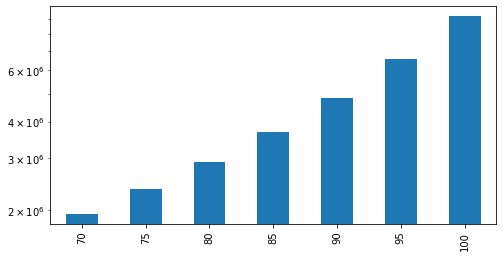

In [109]:
pd.Series(matches_sum_list, index=distance_list).loc[70:].plot.bar(logy=True,figsize=(8, 4))

In [32]:
metrics_per_distance = pd.concat(metrics_list, axis=1, keys=distance_list)

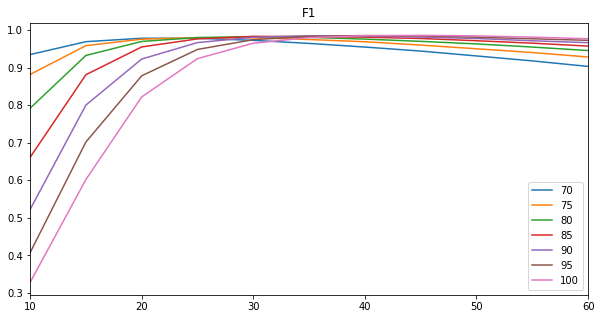

In [113]:
metrics_per_distance.loc[10:60,(range(70, 105),"F1")].droplevel(1, axis=1).plot(figsize=(10, 5), title="F1")

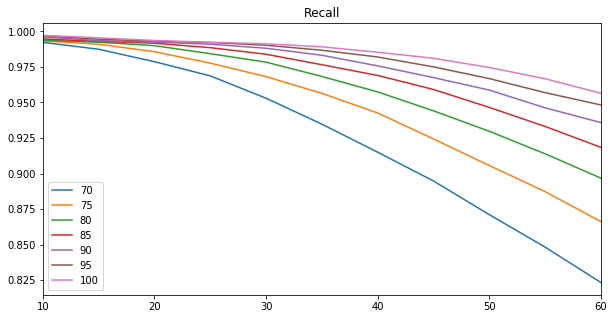

In [112]:
metrics_per_distance.loc[10:60,(range(70, 105),"Recall")].droplevel(1, axis=1).plot(figsize=(10, 5), title="Recall")

In [123]:
metrics_per_distance.loc[:,(range(50, 105),"F1")].droplevel(1, axis=1).idxmax()

50      5
55     10
60     15
65     20
70     20
75     25
80     30
85     30
90     35
95     40
100    45
dtype: int64

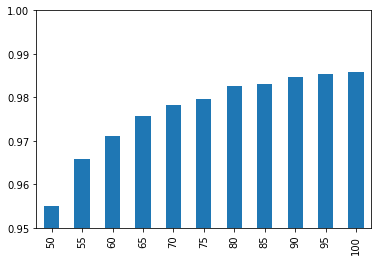

In [125]:
metrics_per_distance.loc[:,(range(50, 105),"F1")].droplevel(1, axis=1).max().plot.bar(ylim=(0.95, 1.0))

In [85]:
times_per_distance = pd.DataFrame(time_list, index=distance_list, columns=["Detection and Extraction", "Descriptor Matching", "Keypoint Selection", "Homography (RANSAC)"])

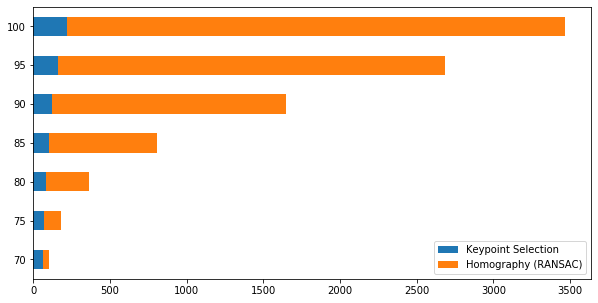

In [111]:
times_per_distance.loc[70:,["Keypoint Selection", "Homography (RANSAC)"]].plot.barh(stacked=True, figsize=(10, 5))

Shortly describing what I did in this section:

I extracted some metrics depending on the size of the radius durching matching. A larger radius means more matches. What I found out:

1. A radius < 70 doesn't really make sense since robustness suffers too much.
2. The number of matches exponentially increases when increasing the radius.
3. It seems a larger radius is especially beneficial for a better and more robust recall.
4. A larger radius means an increased runtime. But the factor doesn't seem to be exponential, contrary to my expectation.
5. A larger radius always increases the overall performance, if even for a small factor.

## Metrics

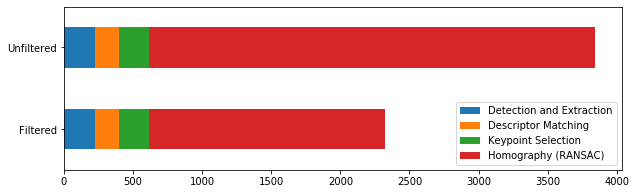

In [154]:
total_time_s = pd.DataFrame([
    [detect_time_s, match_time_s, select_time_s, homography_time_s],
    [detect_time_s, match_time_s, unfiltered_select_time_s, unfiltered_homography_time_s]],
    index=["Filtered", "Unfiltered"],
    columns=["Detection and Extraction", "Descriptor Matching", "Keypoint Selection", "Homography (RANSAC)"])
total_time_s.plot.barh(stacked=True, figsize=(10, 3))
#plt.savefig("runtime.svg", bbox_inches='tight', dpi=300, transparent=True)

In [79]:
thresholds = thresholds = np.arange(0, 100, 5)

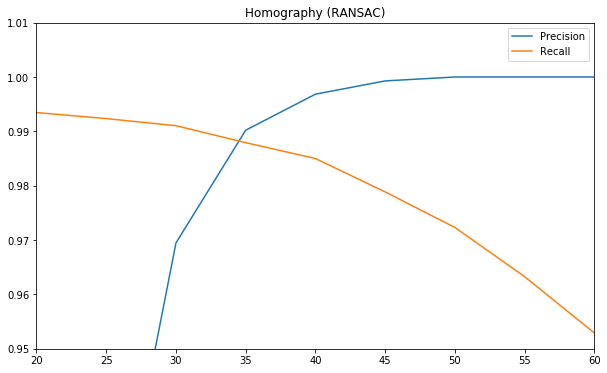

In [353]:
metrics = calculate_metrics(hmask_sum_df, thresholds)
metrics.drop("F1", axis=1).plot(figsize=(10, 6), title="Homography (RANSAC)", ylim=(0.95, 1.01), xlim=(20, 60))

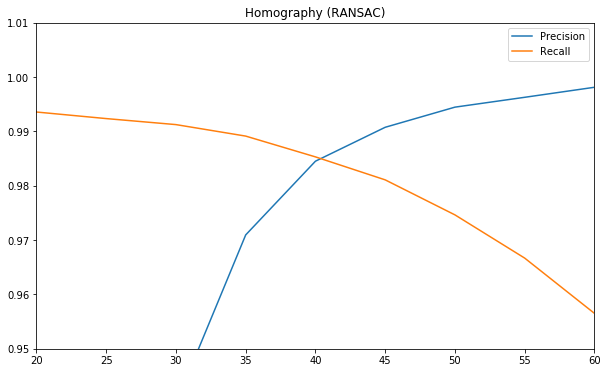

In [352]:
unfiltered_metrics = calculate_metrics(unfiltered_hmask_sum_df, thresholds)
unfiltered_metrics.drop("F1", axis=1).plot(figsize=(10, 6), title="Homography (RANSAC)", ylim=(0.95, 1.01), xlim=(20, 60))

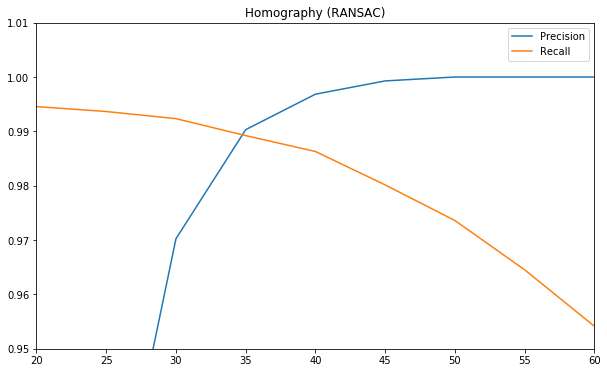

In [351]:
good_homo_metrics = calculate_metrics(hmask_good_sum_df, thresholds)
good_homo_metrics.drop("F1", axis=1).plot(figsize=(10, 6), title="Homography (RANSAC)", ylim=(0.95, 1.01), xlim=(20, 60))

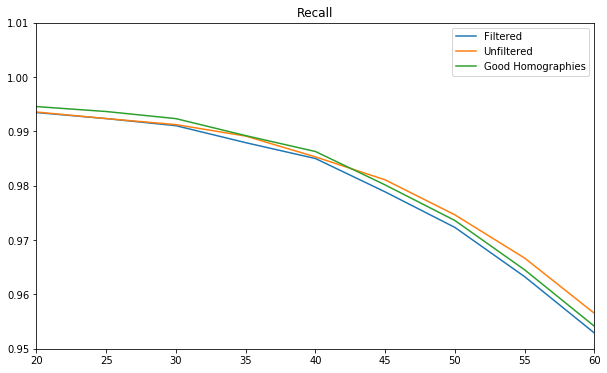

In [356]:
column_keyword = "Recall"
f1_scores = pd.concat(
    [metrics[column_keyword], unfiltered_metrics[column_keyword], good_homo_metrics[column_keyword]],
    axis=1)
f1_scores.columns = ["Filtered", "Unfiltered", "Good Homographies"]
f1_scores.plot(figsize=(10, 6), ylim=(0.95, 1.01), xlim=(20, 60), title=column_keyword)

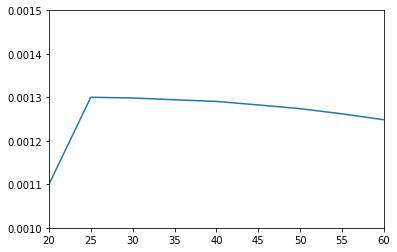

In [368]:
(good_homo_metrics["Recall"] - metrics["Recall"]).plot(xlim=(20, 60), ylim=(0.0010, 0.0015))

# Just extracting some visualizations

Like math formulas for LibreOffice and some keypoint matching images.

In [328]:
np.set_printoptions(suppress=True, floatmode="fixed", precision=2)

In [332]:
def librematrix(a):
    if len(a.shape) > 2:
        raise ValueError('can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = ["alignr matrix{"]
    rv += " ## ".join([" # ".join(l.split()) for l in lines])
    rv +=  ["}"]
    return "".join(rv)

In [333]:
print(librematrix(homo_good.round(2)))

alignr matrix{1.00 # 0.02 # -59.28 ## -0.01 # 1.00 # 22.01 ## -0.00 # 0.00 # 1.00}


In [334]:
print(librematrix(homo_bad.round(2)))

alignr matrix{0.06 # -0.22 # 51.28 ## 0.43 # -1.70 # 389.26 ## 0.00 # -0.00 # 1.00}


In [343]:
kp3 = keypoints["200019548"][60]
kp4 = keypoints["200019548"][page_df.loc[("200019548", "200019558", 60), 0]]

In [348]:
matches1to2 = unfiltered_hmask_matches.loc[("200019548", "200019558", 60), 0]

In [359]:
skp3 = [kp3[m.queryIdx] for m in matches1to2]
skp4 = [kp4[m.trainIdx] for m in matches1to2]

In [371]:
skp3_img = cv.drawKeypoints(img3, skp3, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
skp4_img = cv.drawKeypoints(img4, skp4, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv.imwrite("200019548_60_keypoints.jpg", skp3_img)
#cv.imwrite("200019558_60_keypoints.jpg", skp4_img)

True

In [423]:
results_table = unfiltered_hmask_sum_df.iloc[:,2:7].describe()

In [431]:
results_table

,-2,-1,0,1,2
count,9790.000000,9856.000000,9935.000000,9856.000000,9790.000000
mean,13.496425,13.627739,202.444389,13.835836,13.739224
std,4.277524,4.696309,96.514378,4.961428,4.727201
min,6.000000,6.000000,9.000000,6.000000,6.000000
25%,11.000000,11.000000,133.000000,11.000000,11.000000
50%,13.000000,13.000000,189.000000,13.000000,13.000000
75%,15.000000,15.000000,260.000000,16.000000,16.000000
max,44.000000,66.000000,671.000000,85.000000,69.000000


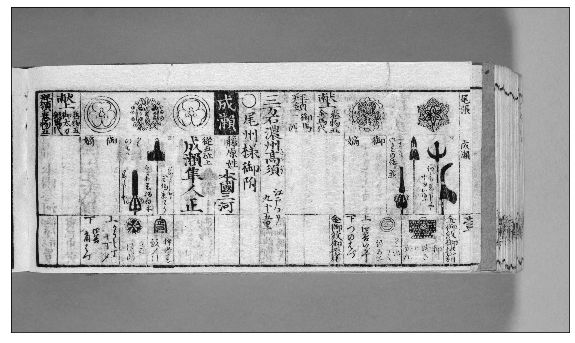

In [175]:
test_height, test_width = test_img.shape
show_image(test_img, (10, 10))

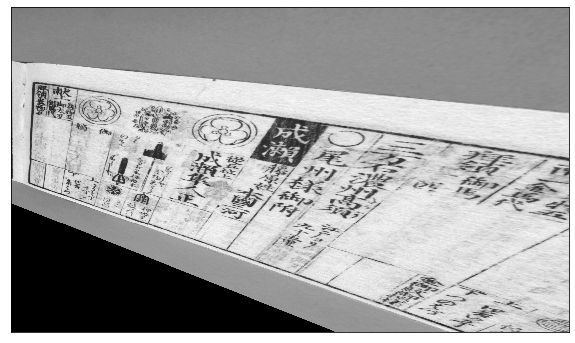

In [264]:
M = np.array([
    [     1,     0,     0],
    [     0,     1,     0],
    [-0.001, 0.001,     1]
], dtype=np.float32)
show_image(cv.warpPerspective(test_img, M, (test_width, test_height)), (10, 10))